In [84]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
(pd.read_csv('data.csv').OM>0).sum()

38

In [86]:
import pandas as pd
df = pd.read_csv('data.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)
df = df.loc['2020-08-28':, :]
df

,GTS,GTS_RATE,DA,OM
Date,,,,
2020-08-28,7.471,-0.929,-0.111257,0.0
2020-08-29,6.679,-0.792,-0.094850,0.0
2020-08-30,5.900,-0.779,-0.093293,0.0
2020-08-31,5.109,-0.791,-0.094731,0.0
2020-09-01,4.329,-0.780,-0.093413,0.0
...,...,...,...,...
2023-07-25,-1.971,-0.895,-0.107186,0.0
2023-07-26,-2.603,-0.632,-0.075689,0.0
2023-07-27,-2.932,-0.329,-0.039401,0.0


In [87]:
(df.OM>0).sum()

37

In [88]:
maneuver_dates = df[df.OM>0].index
len(maneuver_dates)

37

In [89]:
df['Timestamp'] = df.index

def find_last_maneuver_date(timestamp):
    valid_dates = [date for date in maneuver_dates if date < timestamp]
    if valid_dates:
        return max(valid_dates)
    return None


def find_next_maneuver_date(timestamp):
    valid_dates = [date for date in maneuver_dates if date > timestamp]
    if valid_dates:
        return min(valid_dates)
    return None

df['LastManeuverDate'] = df['Timestamp'].apply(find_last_maneuver_date)
df['NextMAneuverDate'] = df['Timestamp'].apply(find_next_maneuver_date)


In [90]:
df['DaysSinceLastManeuver'] = (df['Timestamp'] - df['LastManeuverDate']).dt.days
df['DaysToNextManeuver'] = (df['Timestamp'] - df['LastManeuverDate']).dt.days


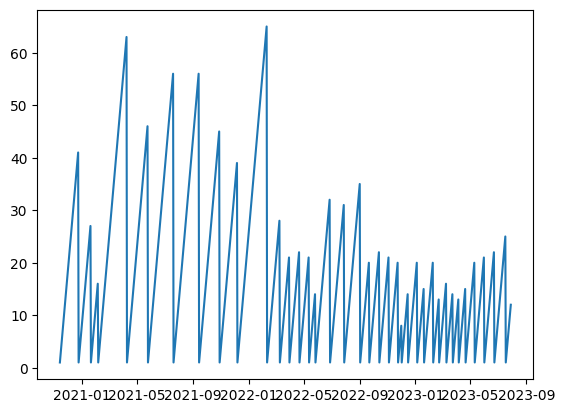

In [91]:
plt.plot(df.DaysToNextManeuver)

In [92]:
import matplotlib.pyplot as plt
sf_data = pd.read_csv('solar_flux_data.csv')
sf_data.DATE = pd.to_datetime(sf_data.DATE)
sf_data.set_index('DATE', inplace = True)

df['solar_flux'] = sf_data.loc['2020-08-28':, :]

In [93]:
df

,GTS,GTS_RATE,DA,OM,Timestamp,LastManeuverDate,NextMAneuverDate,DaysSinceLastManeuver,DaysToNextManeuver,solar_flux
Date,,,,,,,,,,
2020-08-28,7.471,-0.929,-0.111257,0.0,2020-08-28,NaT,2020-11-12,NaN,NaN,70.1
2020-08-29,6.679,-0.792,-0.094850,0.0,2020-08-29,NaT,2020-11-12,NaN,NaN,70.2
2020-08-30,5.900,-0.779,-0.093293,0.0,2020-08-30,NaT,2020-11-12,NaN,NaN,70.0
2020-08-31,5.109,-0.791,-0.094731,0.0,2020-08-31,NaT,2020-11-12,NaN,NaN,69.2
2020-09-01,4.329,-0.780,-0.093413,0.0,2020-09-01,NaT,2020-11-12,NaN,NaN,69.5
...,...,...,...,...,...,...,...,...,...,...
2023-07-25,-1.971,-0.895,-0.107186,0.0,2023-07-25,2023-07-17,NaT,8.0,8.0,169.0
2023-07-26,-2.603,-0.632,-0.075689,0.0,2023-07-26,2023-07-17,NaT,9.0,9.0,167.4
2023-07-27,-2.932,-0.329,-0.039401,0.0,2023-07-27,2023-07-17,NaT,10.0,10.0,165.3


In [94]:
df['isOM'] = [1 if i>0 else  0 for i in df.OM]

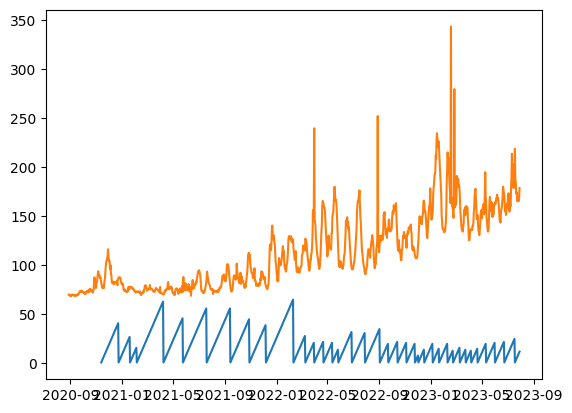

In [98]:
plt.plot(df.DaysToNextManeuver)
plt.plot(df.solar_flux)

In [110]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from lifelines.utils import concordance_index

# Load and preprocess data
# Assuming you have your data loaded into a DataFrame df

# Define covariates and event time
df2 = df.dropna()
X = df2[['DaysSinceLastManeuver','solar_flux', 'GTS']].values
event_time = df2['DaysToNextManeuver'].values
event_occurred = df2['isOM'].values  # 0 if not occurred, 1 if occurred

# Split data into train and validation sets
train_indices = np.random.choice(len(X), size=int(0.8 * len(X)), replace=False)
val_indices = np.setdiff1d(np.arange(len(X)), train_indices)

X_train, X_val = X[train_indices], X[val_indices]
event_time_train, event_time_val = event_time[train_indices], event_time[val_indices]
event_occurred_train, event_occurred_val = event_occurred[train_indices], event_occurred[val_indices]

# Define a parametric deep neural network model
def build_model(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create and train the model
input_dim = X_train.shape[1]
model = build_model(input_dim)
model.fit(X_train, event_time_train, epochs=100, batch_size=32, verbose=0)

# Predict survival times for validation data
predicted_times = model.predict(X_val).flatten()

# Calculate the concordance index
c_index = concordance_index(event_time_val, -predicted_times, event_occurred_val)
print("Concordance Index:", c_index)


7/7 [==============================] - 0s 2ms/step
Concordance Index: 0.046464646464646465


In [111]:
output = pd.DataFrame({'predictions': predicted_times, 
          'actual': event_time_val})
output

,predictions,actual
0,1.026804,1.0
1,2.021706,2.0
2,4.010521,4.0
3,26.999220,27.0
4,33.020370,33.0
...,...,...
191,20.028633,20.0
192,3.012367,3.0
193,11.015942,11.0
194,4.013618,4.0


In [115]:
event_times = df[df.OM>0].DaysToNextManeuver
test_X = (df[df.OM>0])[['DaysSinceLastManeuver','solar_flux', 'GTS']].values

predicted_times = model.predict(test_X).flatten()


output = pd.DataFrame({'predictions': predicted_times, 
          'actual': event_times})
output


2/2 [==============================] - 0s 2ms/step


,predictions,actual
Date,,
2020-11-12,NaN,NaN
2020-12-23,41.007954,41.0
2021-01-19,27.024529,27.0
2021-02-04,16.012457,16.0
2021-04-08,62.931164,63.0
2021-05-24,45.895145,46.0
2021-07-19,56.017254,56.0
2021-09-13,56.019238,56.0
2021-10-28,45.034622,45.0
